In [1]:
import warnings

warnings.filterwarnings(action="ignore")

# Data from POH of SW121

In [2]:
import pandas as pd
import numpy as np

altitude_validation_points = np.array(
    [
        2000.0,
        2000.0,
        2000.0,
        2000.0,
        2000.0,
        4000.0,
        4000.0,
        4000.0,
        4000.0,
        6000.0,
        6000.0,
        6000.0,
        8000.0,
        8000.0,
        8000.0,
        10000.0,
        10000.0,
        12000.0,
    ]
)
rpm_validation_points = np.array(
    [
        5500.0,
        5500.0,
        5300.0,
        4900.0,
        4600.0,
        5500.0,
        5500.0,
        5100.0,
        4600.0,
        5500.0,
        5300.0,
        4900.0,
        5500.0,
        5300.0,
        5100.0,
        5300.0,
        5500.0,
        5500.0,
    ]
)
power_validation_points = (
    np.array(
        [
            1.0,
            0.85,
            0.75,
            0.65,
            0.55,
            0.85,
            0.75,
            0.65,
            0.55,
            0.75,
            0.65,
            0.55,
            0.75,
            0.65,
            0.55,
            0.65,
            0.55,
            0.55,
        ]
    )
    * 69.0
)  # Power is given as percentage of MCP
map_validation_points = np.array(
    [
        27.7,
        26.7,
        25.7,
        24.7,
        24.0,
        25.3,
        24.3,
        23.3,
        23.3,
        23.3,
        22.7,
        22.0,
        22.0,
        21.7,
        21.0,
        19.7,
        20.3,
        18.,
    ]
)  # In inHg
vol_ff_validation_points = np.array(
    [
        28.8,
        22.4,
        18.4,
        16.0,
        14.4,
        25.2,
        19.6,
        16.8,
        15.6,
        23.2,
        19.6,
        16.8,
        23.6,
        21.2,
        18.0,
        22.4,
        19.2,
        20.4,
    ]
)  # In l/h

displacement_volume = 1352.0  # In cm**3
displacement_volume /= 1e6

mep_validation_points = (power_validation_points * 2.0 * np.pi * 4.0) / (displacement_volume * rpm_validation_points * 2.0 * np.pi / 60.0)

# Regression for sfc

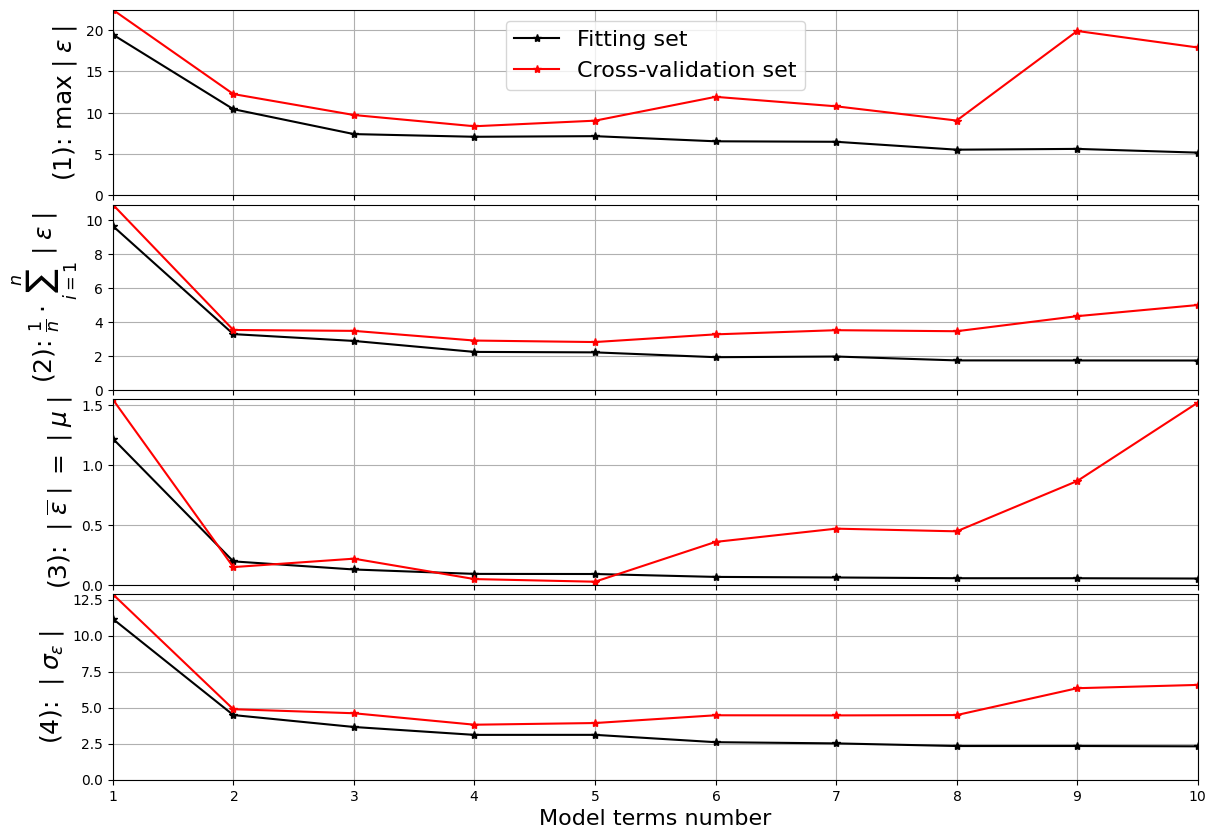


Elected model for regression is n°4:


<IPython.core.display.Latex object>

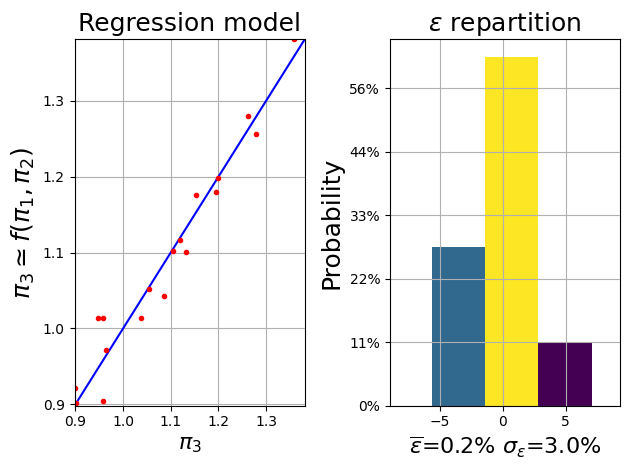

('$\\overline{\\epsilon}$=0.2% $\\sigma_{\\epsilon}$=3.0%',
 '$\\pi_{3} = 0.06437+6.92209 \\cdot \\pi_{1}+5.17683 \\cdot \\pi_{2}^3-11.05164 \\cdot \\pi_{1} \\cdot \\pi_{2}$')

In [3]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import regression_models, perform_regression

import pandas as pd

from stdatm import Atmosphere

sigma_validation_points = (
    Atmosphere(altitude_validation_points, altitude_in_feet=True).density
    / Atmosphere(0).density
)
rpm_ratio_validation_points = rpm_validation_points / 5500.0

# Multiplicative factor to sfc at max rpm sea level
sfc_validation_point = vol_ff_validation_points * 0.72 / power_validation_points * 1000.0  # in g/kWh
k_sfc_validation_points = sfc_validation_point / 285.0

pi1 = sigma_validation_points
pi2 = map_validation_points / 29.92  # SL pressure in inHg
# pi2 = mep_validation_points / 29.92  # SL pressure in inHg
pi3 = k_sfc_validation_points
doe_sfc = np.c_[pi1, pi2, pi3]
doe_sfc = pd.DataFrame(doe_sfc, columns=["pi1", "pi2", "pi3"])

# Fit with 3rd order power-law model the obtained Pi DOE
model = regression_models(
    doe_sfc.values, elected_pi0="pi3", order=3, log_space=False, test_mode=True
)
perform_regression(doe_sfc.values, model, chosen_model=4)

# Regression to link power rate to MAP

Power rate seems like a better fit to estimate the MAP but that means that we must be vigilant that the polynomial doesn't diverge when the power rate goes above 1 (which might happen in eatly loops)

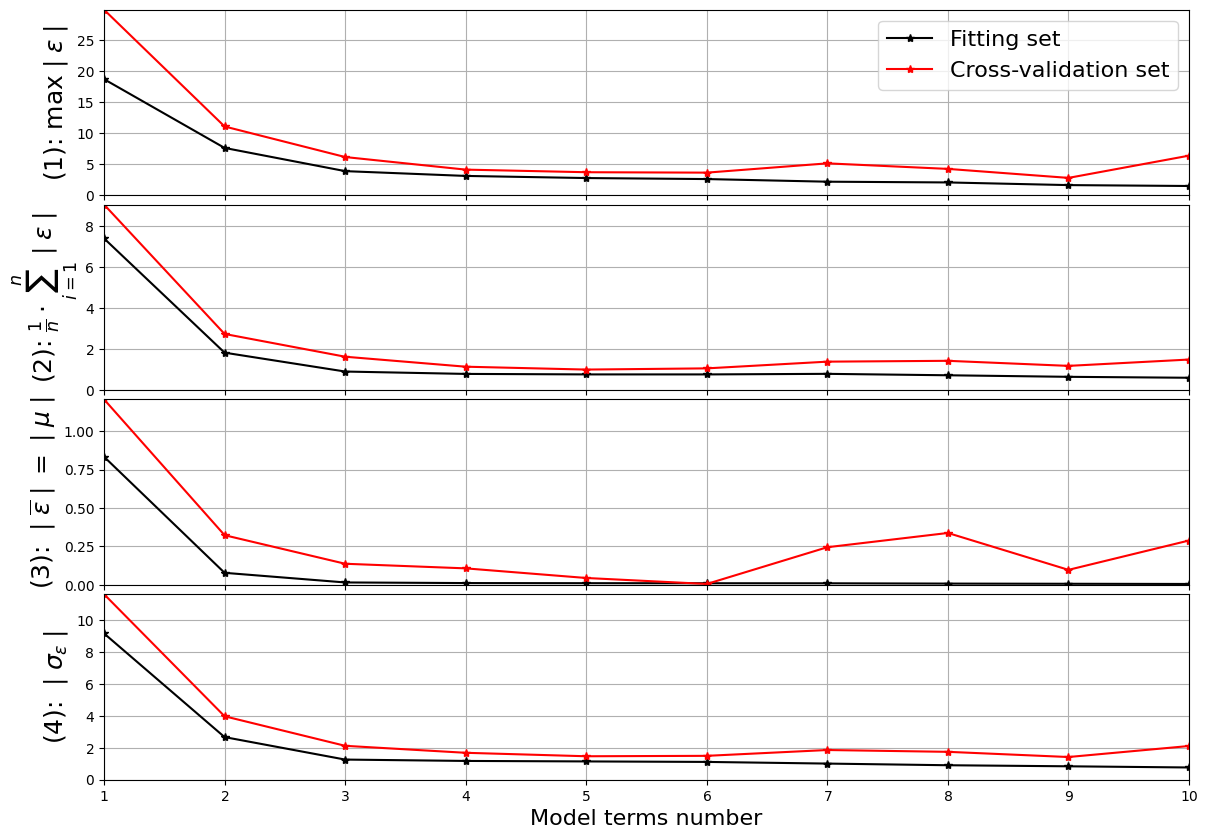


Elected model for regression is n°4:


<IPython.core.display.Latex object>

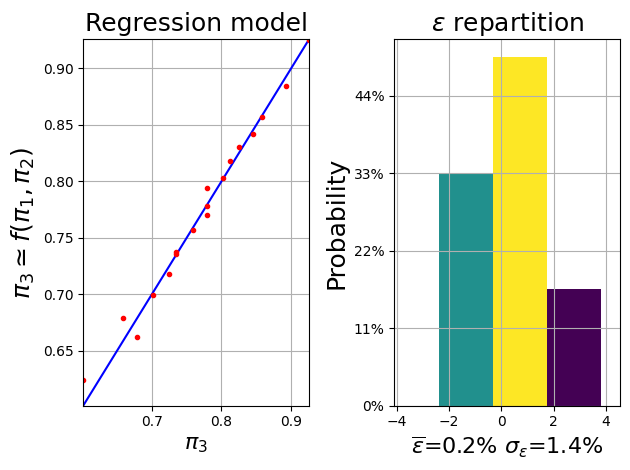

('$\\overline{\\epsilon}$=0.2% $\\sigma_{\\epsilon}$=1.4%',
 '$\\pi_{3} =-0.25089+0.30569 \\cdot \\pi_{1}^2 \\cdot \\pi_{2}+1.66572 \\cdot \\pi_{1}-0.74920 \\cdot \\pi_{1}^2$')

In [4]:
pi1 = sigma_validation_points
pi2 = power_validation_points / 69.0
pi3 = map_validation_points / 29.92  # SL pressure in inHg

doe_map = np.c_[pi1, pi2, pi3]
doe_map = pd.DataFrame(doe_map, columns=["pi1", "pi2", "pi3"])

# Fit with 3rd order power-law model the obtained Pi DOE
model = regression_models(
    doe_map.values, elected_pi0="pi3", order=3, log_space=False, test_mode=True
)
perform_regression(doe_map.values, model, chosen_model=4)

In [5]:
def manifold_pressure(density_ratio, power_rate):
    """Returns the MAP in inHg."""
    map_ratio = -0.25089 + 0.30569 * density_ratio ** 2.0 * power_rate + 1.66572 * density_ratio - 0.74920 * density_ratio ** 2.0
    
    return map_ratio * 29.92

def sfc(density_ratio, manifold_pressure):
    """Returns the sfc in g/kWh."""
    
    sfc_ratio = 0.06437 + 6.92209 * density_ratio + 5.17683 * manifold_pressure ** 3. - 11.05164 * density_ratio * manifold_pressure

    return sfc_ratio * 285.0

def r2(ref_values, interp_values):
    
    return 1.0 - np.sum((ref_values - interp_values) ** 2) / np.sum( (ref_values - np.mean(ref_values)) ** 2)

In [6]:
map_cross_ref = manifold_pressure(sigma_validation_points, power_validation_points / 69.0)
print(map_cross_ref)
print(map_validation_points)

sfc_cross_ref = sfc(sigma_validation_points, map_cross_ref / 29.92)
print(sfc_cross_ref)
print(sfc_validation_point)

vol_ff_cross_ref = sfc_cross_ref * power_validation_points / 1000.0 / 0.72

print(vol_ff_cross_ref)
print(vol_ff_validation_points)

[27.68513049 26.46572351 25.65278552 24.83984753 24.02690954 25.20621087
 24.48484879 23.76348671 23.04212463 23.28259984 22.64358636 22.00457287
 22.0560588  21.49098366 20.92590852 20.31546684 19.81667476 18.6863779 ]
[27.7 26.7 25.7 24.7 24.  25.3 24.3 23.3 23.3 23.3 22.7 22.  22.  21.7
 21.  19.7 20.3 18. ]
[299.4423288  272.71803078 262.16458954 257.21419978 257.68930055
 295.98806126 289.83706494 287.89701093 290.04383825 313.85602734
 314.39840542 317.99669311 334.99474199 337.47946671 342.23219608
 357.72970249 363.31578963 381.68387323]
[300.52173913 274.98721228 256.         256.85618729 273.20158103
 309.36061381 272.69565217 269.69899666 295.96837945 322.7826087
 314.64882943 318.73517787 328.34782609 340.33444816 341.50197628
 359.59866221 364.2687747  387.03557312]
[28.69655651 22.21515626 18.84307987 16.02230119 13.58237355 24.11069416
 20.83203904 17.93358464 15.28772731 22.55840196 19.58440067 16.7610757
 24.07774708 21.02215845 18.03848867 22.28357938 19.14976974 20.1

# Verfication time

Now we will check the results on another aircraft using the same Rotax (Tecnam P2006T), and check anther aircraft using another Rotax (like the 914 if possible).

In [7]:
p2006t_altitude = np.array([0., 0., 0., 3000., 3000., 3000., 6000., 6000., 9000.])  # In ft
p2006t_power_ratio = np.array([0.83, 0.63, 0.50, 0.85, 0.65, 0.48, 0.54, 0.62, 0.65])  # In %
p2006t_map = np.array([28.0, 26.0, 24.0, 26.4, 24.0, 22.0, 20.0, 22.0, 21.1])  # In inHg
p2006t_ff = np.array([23.1, 17.5, 14.1, 23.6, 18.1, 13.3, 14.9, 17.2, 18.3])  # In l/h

p2006t_computed_sigma = (
    Atmosphere(p2006t_altitude, altitude_in_feet=True).density
    / Atmosphere(0).density
)

p2006t_computed_map = manifold_pressure(p2006t_computed_sigma, p2006t_power_ratio)
print("Computed MAP", p2006t_computed_map)
print("Actual MAP", p2006t_map)
print("R2 MAP", r2(p2006t_map, p2006t_computed_map))

p2006t_computed_sfc = sfc(p2006t_computed_sigma, p2006t_computed_map / 29.92)
p2006t_computed_ff = p2006t_computed_sfc * p2006t_power_ratio * 69.0 / 1000.0 / 0.72
print("Computed FF", p2006t_computed_ff)
print("Actual FF", p2006t_ff)
print("R2 MAP", r2(p2006t_ff, p2006t_computed_ff))

Computed MAP [27.50703278 25.67778382 24.488772   25.83971589 24.30782986 23.00572673
 21.94067152 22.45188231 20.90551678]
Actual MAP [28.  26.  24.  26.4 24.  22.  20.  22.  21.1]
R2 MAP 0.89536196716207
Computed FF [19.24034975 13.31932289 10.64384285 23.19594565 17.01387526 12.79352203
 16.48347607 18.72581282 21.6730256 ]
Actual FF [23.1 17.5 14.1 23.6 18.1 13.3 14.9 17.2 18.3]
R2 MAP 0.4075246355237956
